# Imports

In [1]:
import os
import torch
import json
import requests
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset, SyntheticNonlinear, SyntheticDataset0, SyntheticDataset1, SyntheticDataset2, SyntheticDataset3
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder, MonetDense
from spatial.train import train
from spatial.predict import test

import hydra
from hydra.experimental import compose, initialize

import warnings
warnings.filterwarnings("ignore")

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.10/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcusparse.so.11: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Data Framework

![SyntheticFDR](static/syntheticFDR.JPG)

# Create the new synthetic dataset.

In [2]:
class SyntheticFDR(MerfishDataset):
    @property
    def raw_file_names(self):
        return ["synthFDR.csv", "synthFDR.hdf5"]

    @property
    def merfish_csv(self):
        return os.path.join(self.raw_dir, "synthFDR.csv")

    @property
    def merfish_hdf5(self):
        return os.path.join(self.raw_dir, "synthFDR.hdf5")

    @staticmethod
    def _f(edges, data, i, LIGAND_INDEX_1=20):
        all_neighbors = edges[:, edges[0] == i][1]
        random_neighbor = all_neighbors[torch.randint(len(all_neighbors), (1,)).item()]
        return torch.exp(data[random_neighbor, LIGAND_INDEX_1])

    def download(self):

        LIGAND_INDEX_1 = 20
        LIGAND_INDEX_2 = 38

        # download csv if necessary
        if not os.path.exists(self.merfish_csv):
            with open(self.merfish_csv, "wb") as csvf:
                csvf.write(requests.get(self.url, timeout=180).content)

        # process csv if necessary
        dataframe = pd.read_csv(self.merfish_csv)
        preserve_columns = dataframe.columns
        torch.manual_seed(88)
        new_dataframe = pd.DataFrame(columns=preserve_columns)
        FDR_radius = 20
        unique_slices = dataframe.drop_duplicates(["Animal_ID", "Bregma"])[
            ["Animal_ID", "Bregma"]
        ]
        for i in range(len(unique_slices)):
            animal_id, bregma = unique_slices.iloc[i]
            sub_dataframe = dataframe[
                (dataframe["Animal_ID"] == animal_id) & (dataframe["Bregma"] == bregma)
            ]
            edges = self.calculate_neighborhood(
                torch.tensor(sub_dataframe.to_numpy()[:, 5:7].astype("float64")),
                radius=FDR_radius,
                n_neighbors=None,
            ).to("cuda:0")
            sub_dataframe = sub_dataframe.to_numpy()
            sub_dataframe[:, 9:] = torch.distributions.half_normal.HalfNormal(
                (torch.pi / 2) ** 2
            ).sample(sub_dataframe[:, 9:].shape)
            expressions = torch.tensor(sub_dataframe[:, 9:].astype("float64")).to(
                "cuda:0"
            )
            sub_dataframe[:, 9:][:, 0] = np.exp(
                expressions[:, LIGAND_INDEX_1].cpu().numpy()
            )
            sub_dataframe[:, 9:][:, LIGAND_INDEX_2] = torch.arange(
                len(sub_dataframe), dtype=torch.float64
            ).apply_(
                lambda i, edges=edges, x=expressions: self._f(
                    edges, x, i, LIGAND_INDEX_1
                )
            )
            new_dataframe = new_dataframe.append(
                pd.DataFrame(sub_dataframe, columns=preserve_columns)
            )

        new_dataframe = new_dataframe.astype(
            {
                "Animal_ID": "int64",
                "Bregma": "float64",
                "Centroid_X": "float64",
                "Centroid_Y": "float64",
            }
        )

        with h5py.File(self.merfish_hdf5, "w") as h5f:
            # pylint: disable=no-member
            for colnm, dtype in zip(new_dataframe.keys()[:9], new_dataframe.dtypes[:9]):
                if dtype.kind == "O":
                    data = np.require(new_dataframe[colnm], dtype="S36")
                    h5f.create_dataset(colnm, data=data)
                else:
                    h5f.create_dataset(colnm, data=np.require(new_dataframe[colnm]))

            expression = np.array(new_dataframe[new_dataframe.keys()[9:]]).astype(
                np.float64
            )
            h5f.create_dataset("expression", data=expression, dtype="float64")

            gene_names = np.array(new_dataframe.keys()[9:], dtype="S80")
            h5f.create_dataset("gene_names", data=gene_names)

In [6]:
FDR_Dataset = SyntheticFDR('../data', splits = 0, radius = 0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:25<00:00,  1.31s/it]


# Train and Test a Spatially Aware Model

In [3]:
# without try except
test_loss_rad_dict = {}
rad = 25

with initialize(config_path="../config"):
    cfg_from_terminal = compose(config_name="configFDR")
    OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
    OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
    OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
    OmegaConf.update(cfg_from_terminal, "training.logger_name", "FDR_test")
    OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
    OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 154)
    OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
    OmegaConf.update(cfg_from_terminal, "radius", rad)
    OmegaConf.update(cfg_from_terminal, "gpus", [2])
    print(cfg_from_terminal.training.filepath)
    train(cfg_from_terminal)
    output = test(cfg_from_terminal)
    trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
    test_loss_rad_dict[rad] = test_results[0]['test_loss']

MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:27<00:00,  1.32s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | dense_network | DenseReluGMMConvNetwork | 23.6 M
----------------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.564    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 153: 'val_loss' reached 0.97156 (best 0.97156), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 306: 'val_loss' reached 0.07509 (best 0.07509), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 459: 'val_loss' reached 0.01209 (best 0.01209), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 612: 'val_loss' reached 0.00104 (best 0.00104), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 765: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 918: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1071: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1224: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1377: 'val_loss' reached 0.00025 (best 0.00025), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1530: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1683: 'val_loss' reached 0.00022 (best 0.00022), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1836: 'val_loss' reached 0.00017 (best 0.00017), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1989: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2142: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 2295: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 2448: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 2601: 'val_loss' reached 0.00007 (best 0.00007), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 2754: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 2907: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 3060: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 3213: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 3366: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 3519: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 3672: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 3825: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 3978: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 4131: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 4284: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 4437: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 4590: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 4743: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 4896: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 5049: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 5202: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 5355: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 5508: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 5661: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 5814: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 5967: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 6120: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 6273: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 6426: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 6579: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 6732: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 6885: 'val_loss' reached 0.00006 (best 0.00006), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 7038: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 7191: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 7344: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 7497: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 7650: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 7803: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 7956: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 52, global step 8109: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 53, global step 8262: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 54, global step 8415: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 55, global step 8568: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 56, global step 8721: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 57, global step 8874: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 58, global step 9027: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 59, global step 9180: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 60, global step 9333: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 61, global step 9486: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 62, global step 9639: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 63, global step 9792: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 64, global step 9945: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 65, global step 10098: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 66, global step 10251: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 67, global step 10404: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 68, global step 10557: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 69, global step 10710: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 70, global step 10863: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 71, global step 11016: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 72, global step 11169: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 73, global step 11322: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 74, global step 11475: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 75, global step 11628: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 76, global step 11781: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 77, global step 11934: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 78, global step 12087: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 79, global step 12240: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 80, global step 12393: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 81, global step 12546: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 82, global step 12699: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 83, global step 12852: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 84, global step 13005: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 85, global step 13158: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 86, global step 13311: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 87, global step 13464: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 88, global step 13617: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 89, global step 13770: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 90, global step 13923: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 91, global step 14076: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 92, global step 14229: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 93, global step 14382: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 94, global step 14535: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 95, global step 14688: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 96, global step 14841: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 97, global step 14994: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 98, global step 15147: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 99, global step 15300: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 100, global step 15453: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 101, global step 15606: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 102, global step 15759: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 103, global step 15912: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 104, global step 16065: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 105, global step 16218: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 106, global step 16371: 'val_loss' reached 0.00005 (best 0.00005), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 107, global step 16524: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 108, global step 16677: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 109, global step 16830: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 110, global step 16983: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 111, global step 17136: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 112, global step 17289: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 113, global step 17442: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 114, global step 17595: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 115, global step 17748: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 116, global step 17901: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 117, global step 18054: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 118, global step 18207: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 119, global step 18360: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 120, global step 18513: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 121, global step 18666: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 122, global step 18819: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 123, global step 18972: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 124, global step 19125: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 125, global step 19278: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 126, global step 19431: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 127, global step 19584: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 128, global step 19737: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 129, global step 19890: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 130, global step 20043: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 131, global step 20196: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 132, global step 20349: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 133, global step 20502: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 134, global step 20655: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 135, global step 20808: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 136, global step 20961: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 137, global step 21114: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 138, global step 21267: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 139, global step 21420: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 140, global step 21573: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 141, global step 21726: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 142, global step 21879: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 143, global step 22032: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 144, global step 22185: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 145, global step 22338: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 146, global step 22491: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 147, global step 22644: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 148, global step 22797: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 149, global step 22950: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 150, global step 23103: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 151, global step 23256: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 152, global step 23409: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 153, global step 23562: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 154, global step 23715: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 155, global step 23868: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 156, global step 24021: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 157, global step 24174: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 158, global step 24327: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 159, global step 24480: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 160, global step 24633: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 161, global step 24786: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 162, global step 24939: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 163, global step 25092: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 164, global step 25245: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 165, global step 25398: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 166, global step 25551: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 167, global step 25704: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 168, global step 25857: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 169, global step 26010: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 170, global step 26163: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 171, global step 26316: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 172, global step 26469: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 173, global step 26622: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 174, global step 26775: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 175, global step 26928: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 176, global step 27081: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 177, global step 27234: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 178, global step 27387: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 179, global step 27540: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 180, global step 27693: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 181, global step 27846: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 182, global step 27999: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 183, global step 28152: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 184, global step 28305: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 185, global step 28458: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 186, global step 28611: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 187, global step 28764: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 188, global step 28917: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 189, global step 29070: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 190, global step 29223: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 191, global step 29376: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 192, global step 29529: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 193, global step 29682: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 194, global step 29835: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 195, global step 29988: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 196, global step 30141: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 197, global step 30294: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 198, global step 30447: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 199, global step 30600: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 200, global step 30753: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 201, global step 30906: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 202, global step 31059: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 203, global step 31212: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 204, global step 31365: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 205, global step 31518: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 206, global step 31671: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 207, global step 31824: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 208, global step 31977: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 209, global step 32130: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 210, global step 32283: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 211, global step 32436: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 212, global step 32589: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 213, global step 32742: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 214, global step 32895: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 215, global step 33048: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 216, global step 33201: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 217, global step 33354: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 218, global step 33507: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 219, global step 33660: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 220, global step 33813: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 221, global step 33966: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 222, global step 34119: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 223, global step 34272: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 224, global step 34425: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 225, global step 34578: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 226, global step 34731: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 227, global step 34884: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 228, global step 35037: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 229, global step 35190: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 230, global step 35343: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 231, global step 35496: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 232, global step 35649: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 233, global step 35802: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 234, global step 35955: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 235, global step 36108: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 236, global step 36261: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 237, global step 36414: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 238, global step 36567: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 239, global step 36720: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 240, global step 36873: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 241, global step 37026: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 242, global step 37179: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 243, global step 37332: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 244, global step 37485: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 245, global step 37638: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 246, global step 37791: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 247, global step 37944: 'val_loss' reached 0.00004 (best 0.00004), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 248, global step 38097: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 249, global step 38250: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=250` reached.
FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   5.668060475727543e-05   │
│       test_loss_mse       │   5.668060475727543e-05   │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

In [8]:
# with try except
test_loss_rad_dict = {}
rad = 25

with initialize(config_path="../config"):
    try:
        cfg_from_terminal = compose(config_name="configFDR")
        OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
        OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
        OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
        OmegaConf.update(cfg_from_terminal, "training.logger_name", "FDR_test")
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 154)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
        OmegaConf.update(cfg_from_terminal, "radius", rad)
        OmegaConf.update(cfg_from_terminal, "gpus", [2])
        print(cfg_from_terminal.training.filepath)
        train(cfg_from_terminal)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        test_loss_rad_dict[rad] = test_results[0]['test_loss']
    except:
        try:
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
            print(cfg_from_terminal.training.filepath)
            train(cfg_from_terminal)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[rad] = test_results[0]['test_loss']
        except:
            print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [03:17<00:00,  1.25s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | dense_network | DenseReluGMMConvNetwork | 23.6 M
----------------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.564    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 153: 'val_loss' reached 1.44271 (best 1.44271), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 306: 'val_loss' reached 0.26968 (best 0.26968), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam-v1.ckpt' as top 1


MonetDense__[256, 256, 256, 256, 256, 256]__25__FDR_test__Adam



  1%|█▌                                                                                                                            | 2/157 [00:02<03:52,  1.50s/it]


Model with radius of 25 micrometers doesn't exist :(



KeyboardInterrupt



# Train and Test a Spatially Ignorant Model

In [4]:
rad = 0
with initialize(config_path="../config"):
    try:
        cfg_from_terminal = compose(config_name="configFDR")
        OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
        OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
        OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
        OmegaConf.update(cfg_from_terminal, "training.logger_name", "FDR_test")
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 154)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
        OmegaConf.update(cfg_from_terminal, "radius", rad)
        OmegaConf.update(cfg_from_terminal, "gpus", [2])
        print(cfg_from_terminal.training.filepath)
        train(cfg_from_terminal)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        test_loss_rad_dict[rad] = test_results[0]['test_loss']
    except:
        try:
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
            print(cfg_from_terminal.training.filepath)
            train(cfg_from_terminal)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[rad] = test_results[0]['test_loss']
        except:
            print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam


100%|███████████████████████████████████████████████████████████████████████████| 157/157 [03:58<00:00,  1.52s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]

  | Name          | Type                    | Params
----------------------------------------------------------
0 | dense_network | DenseReluGMMConvNetwork | 23.6 M
----------------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.564    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 153: 'val_loss' reached 0.68893 (best 0.68893), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 306: 'val_loss' reached 0.04689 (best 0.04689), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 459: 'val_loss' reached 0.00420 (best 0.00420), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 612: 'val_loss' reached 0.00298 (best 0.00298), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 765: 'val_loss' reached 0.00185 (best 0.00185), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 918: 'val_loss' reached 0.00170 (best 0.00170), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 1071: 'val_loss' reached 0.00141 (best 0.00141), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 1224: 'val_loss' reached 0.00128 (best 0.00128), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1377: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1530: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1683: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1836: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1989: 'val_loss' reached 0.00015 (best 0.00015), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 2142: 'val_loss' reached 0.00014 (best 0.00014), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 2295: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 2448: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 2601: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 2754: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 2907: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 3060: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 20, global step 3213: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 21, global step 3366: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 22, global step 3519: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 23, global step 3672: 'val_loss' reached 0.00003 (best 0.00003), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 24, global step 3825: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 25, global step 3978: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 26, global step 4131: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 27, global step 4284: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 28, global step 4437: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 29, global step 4590: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 30, global step 4743: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 31, global step 4896: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 32, global step 5049: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 33, global step 5202: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 34, global step 5355: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 35, global step 5508: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 36, global step 5661: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 37, global step 5814: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 38, global step 5967: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 39, global step 6120: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 40, global step 6273: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 41, global step 6426: 'val_loss' reached 0.00002 (best 0.00002), saving model to '/home/roko/spatial/output/lightning_logs/checkpoints/MonetDense/MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 42, global step 6579: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 43, global step 6732: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 44, global step 6885: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 45, global step 7038: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 46, global step 7191: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 47, global step 7344: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 48, global step 7497: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 49, global step 7650: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 50, global step 7803: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 51, global step 7956: 'val_loss' was not in top 1
FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                    

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   1.878494549600873e-05   │
│       test_loss_mse       │   1.878494549600873e-05   │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Test Models Only

### Spatially Aware

In [4]:
# with try except
test_loss_rad_dict = {}
rad = 25

with initialize(config_path="../config"):
    try:
        cfg_from_terminal = compose(config_name="configFDR")
        OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
        OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
        OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
        OmegaConf.update(cfg_from_terminal, "training.logger_name", "FDR_test")
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 154)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
        OmegaConf.update(cfg_from_terminal, "radius", rad)
        OmegaConf.update(cfg_from_terminal, "gpus", [2])
        print(cfg_from_terminal.training.filepath)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        test_loss_rad_dict[rad] = test_results[0]['test_loss']
    except:
        try:
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[rad] = test_results[0]['test_loss']
        except:
            print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__25__FDR_test__Adam



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.41s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   5.216209319769405e-05   │
│       test_loss_mse       │   5.216209319769405e-05   │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

### Spatially Ignorant

In [5]:
rad = 0

with initialize(config_path="../config"):
    try:
        cfg_from_terminal = compose(config_name="configFDR")
        OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
        OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [512, 512, 512, 512, 512, 512])
        OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
        OmegaConf.update(cfg_from_terminal, "training.logger_name", "FDR_test")
        OmegaConf.update(cfg_from_terminal, "datasets.dataset.include_celltypes", False)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.observables_dimension", 154)
        OmegaConf.update(cfg_from_terminal, "model.kwargs.include_skip_connections", True)
        OmegaConf.update(cfg_from_terminal, "radius", rad)
        OmegaConf.update(cfg_from_terminal, "gpus", [2])
        print(cfg_from_terminal.training.filepath)
        output = test(cfg_from_terminal)
        trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
        test_loss_rad_dict[rad] = test_results[0]['test_loss']
    except:
        try:
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [256, 256, 256, 256, 256, 256])
            print(cfg_from_terminal.training.filepath)
            output = test(cfg_from_terminal)
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[rad] = test_results[0]['test_loss']
        except:
            print(f"Model with radius of {rad} micrometers doesn't exist :(")

MonetDense__[512, 512, 512, 512, 512, 512]__0__FDR_test__Adam



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:32<00:00,  1.34s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4,5,6]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   3.110692705377005e-05   │
│       test_loss_mse       │   3.110692705377005e-05   │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  471            	

# Compare the Diff (hopefully it's small)

In [5]:
with open('deepST_synthetic_results.json', 'r') as deepST:
    test_loss_DeepST_dict = json.load(deepST)
    
with open('LightGBM_synthetic_results.json', 'r') as linear:
    linear_models_dict = json.load(linear)
    
import pandas as pd

# linear models + XGBoost
data = pd.DataFrame(columns=['Model', 'Radius', 'Experiment #', 'L2 Loss'])
for k,v in linear_models_dict.items():
    k = k.split()
    entry = pd.DataFrame.from_dict({
        'Model': [k[0]],
        'Radius': [int(k[1])],
        'Experiment #': [k[2]],
        'L2 Loss': [v]
    })
    data = pd.concat([data, entry], ignore_index=True)

print(data)


for k,v in test_loss_DeepST_dict.items():
    try:
        k = eval(k)
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [str(k[1])],
            'L2 Loss': [min(v.values())]
        })
        data = pd.concat([data, entry], ignore_index=True)
    #nonlinear case
    except (AttributeError, ValueError):
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [str(k[1])],
            'L2 Loss': [v]
        })
        data = pd.concat([data, entry], ignore_index=True)

          Model Radius Experiment #   L2 Loss
0      LightGBM      0            0  0.229992
1           OLS      0            0  0.230439
2         Ridge      0            0  0.230426
3         Lasso      0            0  0.231350
4    ElasticNet      0            0  0.230434
..          ...    ...          ...       ...
817       Lasso     55          FDR  0.203158
818    LightGBM     60          FDR  0.001986
819         OLS     60          FDR  0.202371
820       Ridge     60          FDR  0.202371
821       Lasso     60          FDR  0.203158

[822 rows x 4 columns]


In [6]:
data

,Model,Radius,Experiment #,L2 Loss
0,LightGBM,0,0,0.229992
1,OLS,0,0,0.230439
2,Ridge,0,0,0.230426
3,Lasso,0,0,0.23135
4,ElasticNet,0,0,0.230434
...,...,...,...,...
934,deepST,40,2,0.313488
935,deepST,45,2,0.311361
936,deepST,50,2,0.313585
937,deepST,55,2,0.307252


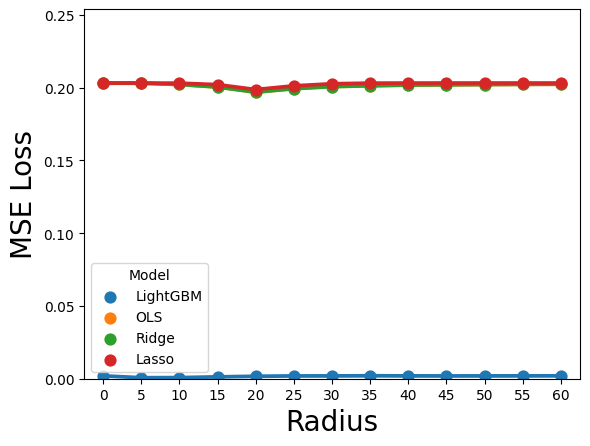

In [12]:
EXPERIMENT_NUM = "FDR"

# create pointplot
plt.rcParams['font.family'] = 'DejaVu Sans'
new_data = data[(data['Experiment #'] == EXPERIMENT_NUM)]
synth_results = sns.pointplot(x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
synth_results.set_ylim(bottom=0, top=1.25*max(new_data["L2 Loss"]))
# baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
# synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
# synth_results.set_title(f"Experiment NONLINEAR", fontsize=25)
synth_results.set_xlabel("Radius", fontsize = 20)
synth_results.set_ylabel("MSE Loss", fontsize = 20)
# plt.gca().set_ylim(bottom=-0.02)
plt.savefig(f'synthetic{EXPERIMENT_NUM}.png', dpi=300, bbox_inches='tight')

In [8]:
# DeepST Ratio
test_loss_rad_dict[25]/test_loss_rad_dict[0]

3.017341986396418

In [9]:
# LightGBM Ratio
GBM_aware = float(data[(data["Model"] == "LightGBM") & (data["Radius"] == 25) & (data["Experiment #"] == "FDR")]["L2 Loss"])
GBM_ignorant = float(data[(data["Model"] == "LightGBM") & (data["Radius"] == 0) & (data["Experiment #"] == "FDR")]["L2 Loss"])
print(f"GBM Aware: {GBM_aware}")
print(f"GBM Ignorant: {GBM_ignorant}")
GBM_aware/GBM_ignorant

GBM Aware: 0.0019015359029911116
GBM Ignorant: 0.0019659551071423047


0.9672326169009869

In [10]:
# Ridge Ratio
Ridge_aware = float(data[(data["Model"] == "Ridge") & (data["Radius"] == 25) & (data["Experiment #"] == "FDR")]["L2 Loss"])
Ridge_ignorant = float(data[(data["Model"] == "Ridge") & (data["Radius"] == 0) & (data["Experiment #"] == "FDR")]["L2 Loss"])
print(f"GBM Aware: {Ridge_aware}")
print(f"GBM Ignorant: {Ridge_ignorant}")
Ridge_aware/Ridge_ignorant

GBM Aware: 0.1993188929752836
GBM Ignorant: 0.20303967474661788


0.9816746073102333

In [21]:
# Lasso Ratio
Lasso_aware = float(data[(data["Model"] == "Lasso") & (data["Radius"] == 25) & (data["Experiment #"] == "FDR")]["L2 Loss"])
Lasso_ignorant = float(data[(data["Model"] == "Lasso") & (data["Radius"] == 0) & (data["Experiment #"] == "FDR")]["L2 Loss"])
print(f"Lasso Aware: {Lasso_aware}")
print(f"Lasso Ignorant: {Lasso_ignorant}")
Lasso_aware/Lasso_ignorant

Lasso Aware: 0.20122831270178895
Lasso Ignorant: 0.2031580847524068


0.9905011309150227

In [22]:
# OLS Ratio
OLS_aware = float(data[(data["Model"] == "OLS") & (data["Radius"] == 25) & (data["Experiment #"] == "FDR")]["L2 Loss"])
OLS_ignorant = float(data[(data["Model"] == "OLS") & (data["Radius"] == 0) & (data["Experiment #"] == "FDR")]["L2 Loss"])
print(f"OLS Aware: {OLS_aware}")
print(f"OLS Ignorant: {OLS_ignorant}")
OLS_aware/OLS_ignorant

OLS Aware: 0.19931884738486114
OLS Ignorant: 0.20306775547202274


0.9815386343417869